In [1]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim

import glob

## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser
from landlab.components import SinkFillerBarnes
from landlab.components import SpatialPrecipitationDistribution


#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 

%matplotlib inline

101
None
101


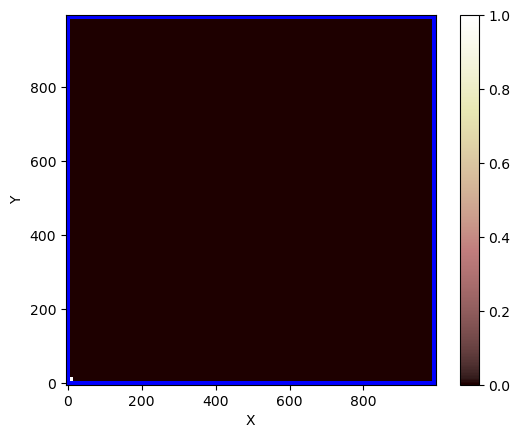

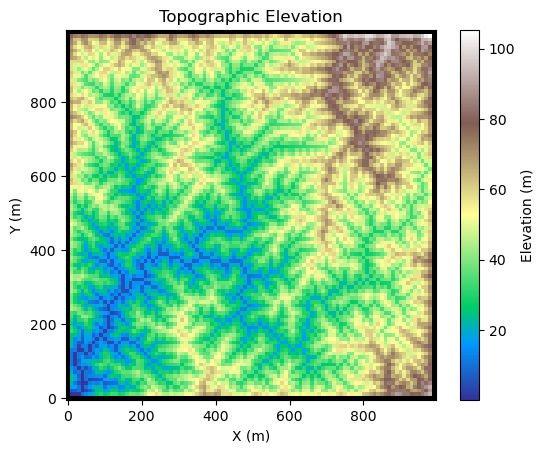

In [2]:
ncols = 932
nrows = 891
cellsize = 9.0321982288432

#mg = RasterModelGrid()
#Set directory paths to retrieve the asc file
path_project = r"" # add the path to the asc file    #this should access my H drive

#topo_dem = "alex_ascii.txt" #the name of the ascii file
topo_dem ="sample_topo2_topographic__elevation.txt"
topo_path = path_project + topo_dem

#now read the header of the asc file (where there is ncols nrows cell size and nodata value) into the string variable dem_header
topo_header = read_asc_header(open(topo_path, 'r'))

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(topo_path, name = 'topographic__elevation', halo = 0)

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)#Close all model boundary edges


#find min elevation
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()

min_topo_ID = open_nodes[min_topo]

print(min_topo_ID)


#outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999.)
outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
#This should find your outlet node automatically and outlet_id will be empty if a single outlet was not found

print(outlet_id) #prints out the outlet_id
outlet_id = min_topo_ID
#print(mg.at_node.keys()) #Shows the node attributes

# FIND OUTLET
#open_nodes = mg.core_nodes
#min_topo = mg['node']['topographic__elevation'].argmin()
#min_topo_ID = open_nodes[min_topo]
#outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
#outlet_id = min_topo_ID




print(outlet_id) #prints out the outlet_id

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
imshow_grid(mg, mg.status_at_node, color_for_closed = 'blue') #creates a graph showing the red and the closed boundaries are set to blue, black is the landscape and white is the outlet ID (cannot see it at this level)


#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
#mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)

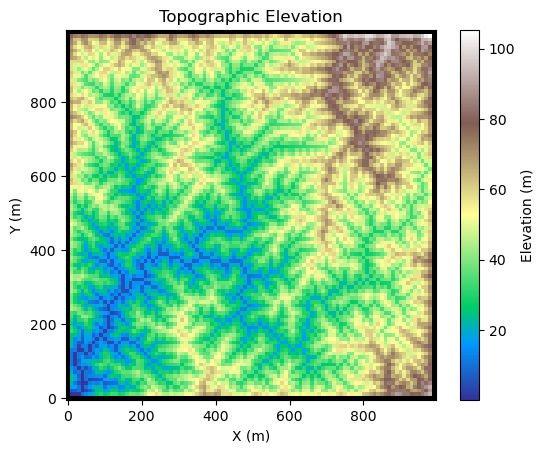

In [3]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

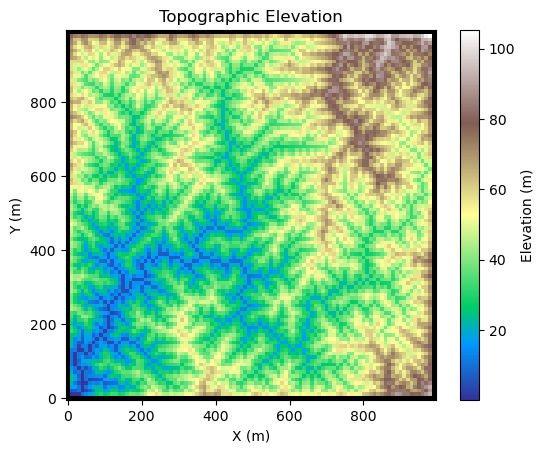

In [4]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

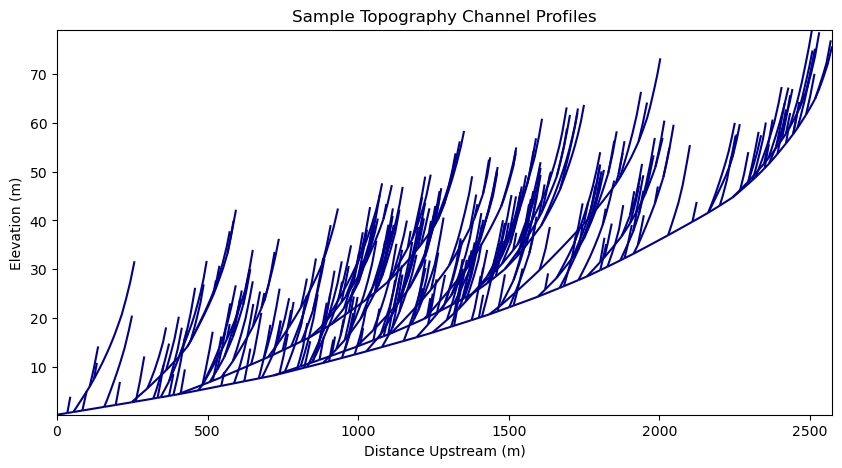

In [8]:

fa = FlowAccumulator(mg, flow_director='D8') 

# RUNNING FSC FOR 1 YEAR TO IDENTIFY CHANNELS 
fa.run_one_step()


prf = ChannelProfiler(mg,number_of_watersheds=1,main_channel_only=False,minimum_channel_threshold=cellsize**3)

prf.run_one_step()
#Show the profile
prof= plt.figure()
prf.plot_profiles(color="darkblue",xlabel='Distance Upstream (m)', ylabel='Elevation (m)', title="Sample Topography Channel Profiles")
prof.set_figwidth(10)
prof.set_figheight(5)
prof.savefig("poster code/other_plots/sample_chan_profile.png", dpi="figure", format=None)